#**DATASET DEL INDICE GEOGRAFICO EN EL PERU**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import LinearRegression
%matplotlib inline

#**primera vista a los datos**

In [ ]:
# Cargar cada archivo
df2021 = pd.read_csv("peru_provincias_region_2021.csv", parse_dates=["DATE"])
df2022 = pd.read_csv("peru_provincias_region_2022.csv", parse_dates=["DATE"])
df2023 = pd.read_csv("peru_provincia_region_2023.csv", sep=";")

# Convert 'DATE' column in df2023 to datetime objects with the correct format
df2023["DATE"] = pd.to_datetime(df2023["DATE"], format="%d/%m/%Y")


# Agregar columna YEAR
df2021["YEAR"] = 2021
df2022["YEAR"] = 2022
df2023["YEAR"] = 2023

# Concatenar
df_all = pd.concat([df2021, df2022, df2023], ignore_index=True)

# Asegurarnos de los tipos
df_all["NAME_0"] = df_all["NAME_0"].astype(str)
df_all["NAME_1"] = df_all["NAME_1"].astype(str)
# Handle the missing 'NAME_2' column in df2023 by filling with a placeholder
df_all["NAME_2"] = df_all["NAME_2"].fillna("Unknown").astype(str)

df_all["SCORE"] = df_all["SCORE"].astype(float)
df_all["N"] = df_all["N"].astype(float)

# Extraemos mes y trimestre para uso posterior
df_all["MONTH"] = df_all["DATE"].dt.to_period("M").astype(str)
df_all["QUARTER"] = df_all["DATE"].dt.to_period("Q").astype(str)

In [ ]:
df2021.head()

,DATE,NAME_0,NAME_1,NAME_2,SCORE,N
0,2021-01-01,Peru,Peru_Ancash,Peru_Ancash_Casma,0.640320,5.0
1,2021-01-01,Peru,Peru_Ancash,Peru_Ancash_Santa,0.684252,82.0
2,2021-01-01,Peru,Peru_Arequipa,Peru_Arequipa_Arequipa,0.662841,168.0
3,2021-01-01,Peru,Peru_Arequipa,Peru_Arequipa_Islay,0.707989,11.0
4,2021-01-01,Peru,Peru_Cajamarca,Peru_Cajamarca_Cajamarca,0.644940,46.0


In [ ]:
df2022.head()

,DATE,NAME_0,NAME_1,NAME_2,SCORE,N
0,2022-01-01,Peru,Peru_Ancash,Peru_Ancash_Huaraz,0.649602,80.0
1,2022-01-01,Peru,Peru_Ancash,Peru_Ancash_Huari,0.801014,1.0
2,2022-01-01,Peru,Peru_Ancash,Peru_Ancash_Santa,0.644240,51.0
3,2022-01-01,Peru,Peru_Arequipa,Peru_Arequipa_Arequipa,0.674796,86.0
4,2022-01-01,Peru,Peru_Arequipa,Peru_Arequipa_Islay,0.707782,7.0


In [ ]:
df2023.head()

,DATE,NAME_0,NAME_1,Column1,SCORE,N
0,01/01/2023,Peru,Peru_Ancash,Peru_Ancash_Huaylas,0.647061,36
1,01/01/2023,Peru,Peru_Ancash,Peru_Ancash_Santa,0.630860,919
2,01/01/2023,Peru,Peru_Apurímac,Peru_Apurímac_Abancay,0.958179,16
3,01/01/2023,Peru,Peru_Arequipa,Peru_Arequipa_Arequipa,0.665502,83
4,01/01/2023,Peru,Peru_Ayacucho,Peru_Ayacucho_Huamanga,0.570680,412


#**ENTENDIENDO LOS DATOS**
**Es importante comprender completamente toda la información proporcionada en los datos. El primer paso es examinar con más detalle todas las columnas y comprender sus tipos.**

In [ ]:
df2023.dtypes

,0
DATE,object
NAME_0,object
NAME_1,object
Column1,object
SCORE,float64
N,int64


In [ ]:
df2021.describe()

,SCORE,N
count,18371.000000,18371.000000
mean,0.582249,86.023080
std,0.145203,587.756238
min,0.008293,1.000000
25%,0.518293,2.000000
50%,0.586261,5.000000
75%,0.660631,22.000000
max,0.985058,11116.000000


#**DATA-PREPROCESING**

#**¿Cómo evolucionó el promedio anual de SCORE para cada región entre 2021, 2022 y 2023?**

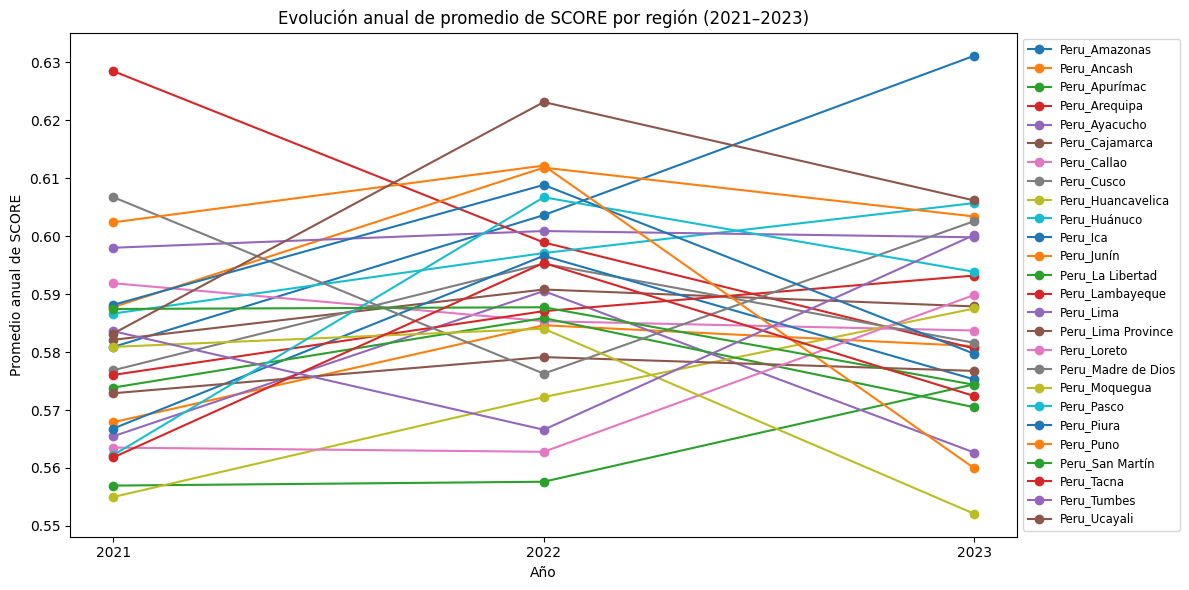

In [ ]:
# 1.1 Cálculo del promedio anual de SCORE por región y año
avg_score_by_region = (
    df_all
    .groupby(["YEAR", "NAME_1"])["SCORE"]
    .mean()
    .reset_index(name="avg_SCORE")
)

# 1.2 Pivot para facilitar trazado: filas=YEAR, columnas=NAME_1, valores=avg_SCORE
pivot_avg_score = avg_score_by_region.pivot(index="YEAR", columns="NAME_1", values="avg_SCORE")

# 1.3 Plot: líneas de promedio de SCORE por región
plt.figure(figsize=(12, 6))
for region in pivot_avg_score.columns:
    plt.plot(
        pivot_avg_score.index,
        pivot_avg_score[region],
        marker="o",
        label=region
    )

plt.xticks([2021, 2022, 2023])
plt.xlabel("Año")
plt.ylabel("Promedio anual de SCORE")
plt.title("Evolución anual de promedio de SCORE por región (2021–2023)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize="small")
plt.tight_layout()
plt.show()


#**¿Cómo se relacionan, a nivel regional (NAME_1), la suma total de N (tuit-volume) versus el promedio anual de SCORE para cada uno de los tres años?**



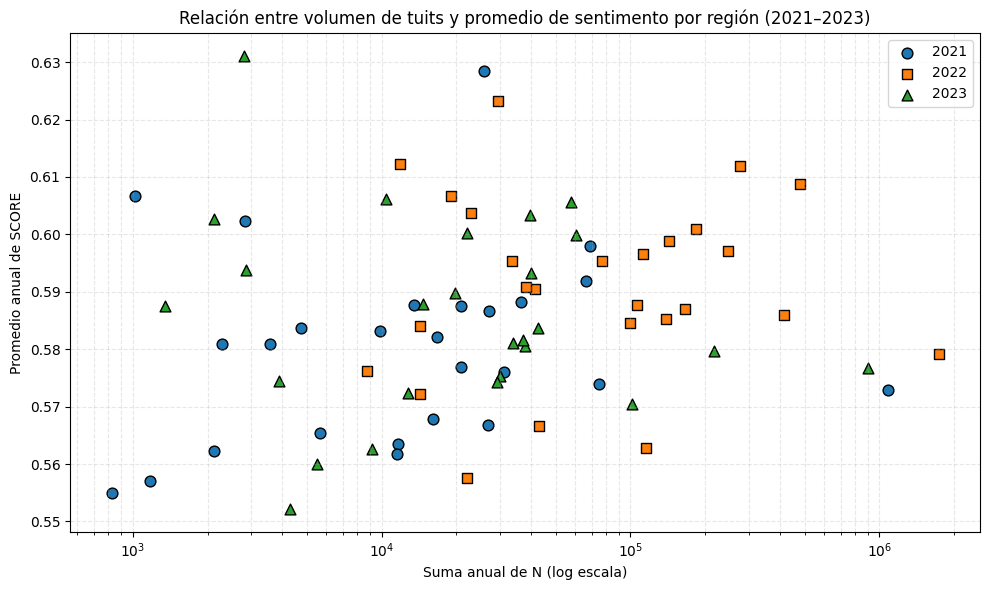

In [ ]:
# 2.1 Calcular suma anual de N y promedio anual de SCORE por región y año
agg_region_year = (
    df_all
    .groupby(["YEAR", "NAME_1"])
    .agg(total_N=("N", "sum"), avg_SCORE=("SCORE", "mean"))
    .reset_index()
)

# 2.2 Separar en DataFrames por año para graficar con distinto color/marker
agg_2021 = agg_region_year[agg_region_year["YEAR"] == 2021]
agg_2022 = agg_region_year[agg_region_year["YEAR"] == 2022]
agg_2023 = agg_region_year[agg_region_year["YEAR"] == 2023]

# 2.3 Scatter plot comparativo
plt.figure(figsize=(10, 6))
plt.scatter(agg_2021["total_N"], agg_2021["avg_SCORE"],
            label="2021", marker="o", edgecolor="black", s=60)
plt.scatter(agg_2022["total_N"], agg_2022["avg_SCORE"],
            label="2022", marker="s", edgecolor="black", s=60)
plt.scatter(agg_2023["total_N"], agg_2023["avg_SCORE"],
            label="2023", marker="^", edgecolor="black", s=60)

plt.xscale("log")  # escala logarítmica para visualizar mejor la amplitud de total_N
plt.xlabel("Suma anual de N (log escala)")
plt.ylabel("Promedio anual de SCORE")
plt.title("Relación entre volumen de tuits y promedio de sentimento por región (2021–2023)")
plt.legend()
plt.grid(alpha=0.3, which="both", linestyle="--")
plt.tight_layout()
plt.show()


Algunas regiones (como Lima) pueden tener más de un millón de tuits, mientras que otras (como Pasco o Huancavelica) pueden tener menos de 1000 tuits.

Si se graficaran esos números en escala lineal, los puntos de bajo volumen quedarían “aplastados” a la izquierda.
Por eso se usa escala logarítmica: permite ver bien tanto los valores pequeños como los grandes.

#**Para una región dada (por ejemplo “Lima”), ¿cómo varía mensualmente el promedio de SCORE a lo largo de cada año (2021, 2022, 2023)?**

<ipython-input-29-487f21f62a43>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lima["DATE"] = pd.to_datetime(df_lima["DATE"])
<ipython-input-29-487f21f62a43>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lima["YEAR"] = df_lima["DATE"].dt.year
<ipython-input-29-487f21f62a43>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

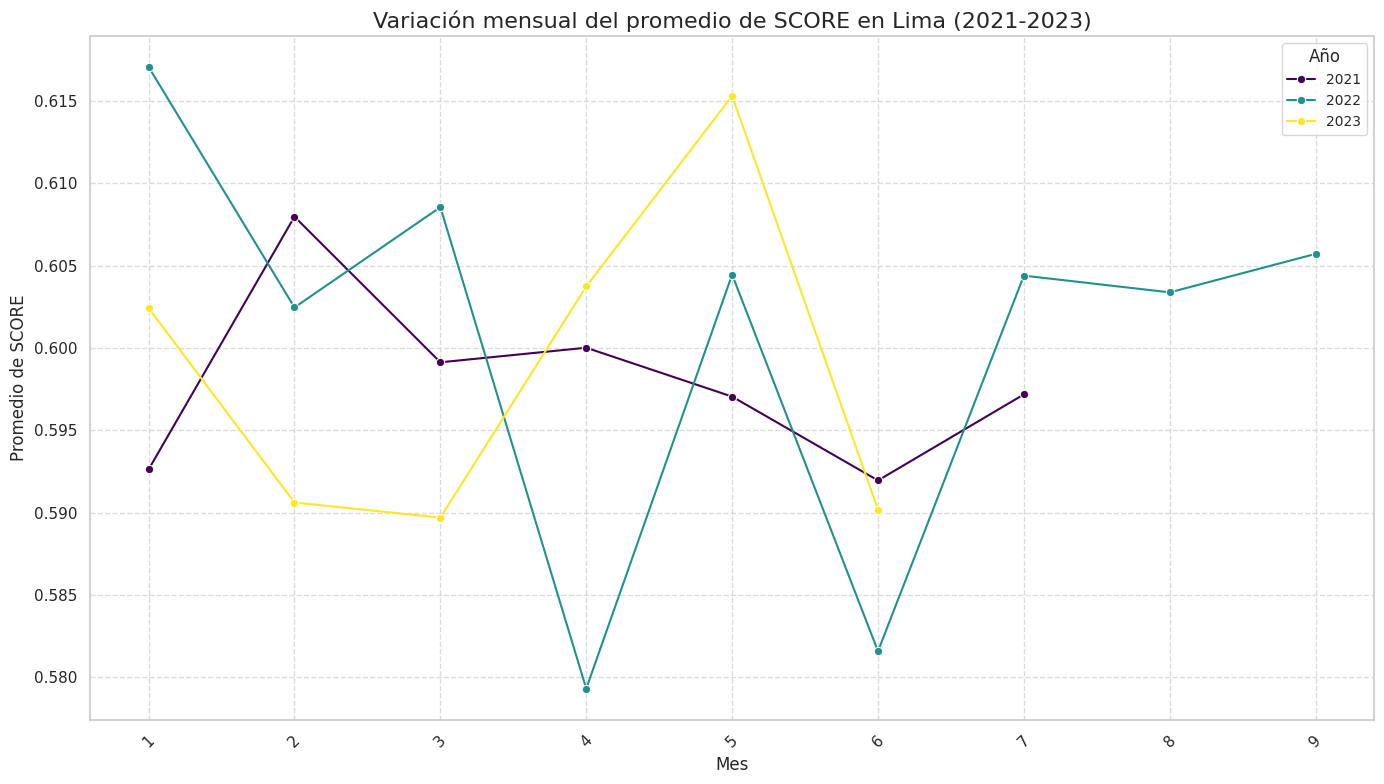

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos (suponiendo que ya has concatenado todos los archivos en `df_all`)
# df_all = pd.concat([df2021, df2022, df2023], ignore_index=True)

# Filtrar por región "Lima"
df_lima = df_all[df_all["NAME_1"] == "Peru_Lima"]

# Asegurarse de que la columna 'DATE' sea datetime
df_lima["DATE"] = pd.to_datetime(df_lima["DATE"])

# Extraer año y mes
df_lima["YEAR"] = df_lima["DATE"].dt.year
df_lima["MONTH"] = df_lima["DATE"].dt.month

# Agrupar por año y mes, calcular el promedio de SCORE
monthly_avg_score = (
    df_lima.groupby(["YEAR", "MONTH"])["SCORE"]
    .mean()
    .reset_index()
)

# Crear tabla pivote: un año por línea, meses en columnas
pivot_score = monthly_avg_score.pivot(index="MONTH", columns="YEAR", values="SCORE")
pivot_score.reset_index(inplace=True)
pivot_score["MONTH"] = pivot_score["MONTH"].astype(str)  # Convertir Mes a string

# Visualización con Seaborn
plt.figure(figsize=(14, 8))

# Configurar estilo de Seaborn
sns.set(style="whitegrid")

# Dibujar líneas para cada año
sns.lineplot(data=pivot_score.melt(id_vars=["MONTH"], value_name="SCORE", var_name="YEAR"),
             x="MONTH",
             y="SCORE",
             hue="YEAR",
             marker="o",
             palette="viridis")  # Usar un paleta de colores distinta

# Personalizar el gráfico
plt.title("Variación mensual del promedio de SCORE en Lima (2021-2023)", fontsize=16)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Promedio de SCORE", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Año", fontsize=10, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Guardar o mostrar el gráfico
plt.show()


### **Valles Pronunciados (Sentimiento Negativo)**
1. **Enero-Febrero 2021**  
   - **Causa:** Segunda ola de COVID-19.  
   - **Impacto:** Colapso de hospitales, falta de oxígeno y récord de muertes diarias.  
   - **Repercusión en redes:** Críticas masivas al gobierno (#OxigenoParaPerú fue tendencia), desesperación y angustia.

2. **Junio 2021**  
   - **Causa:** Elecciones presidenciales polarizadas (Segunda vuelta: Castillo vs. Fujimori).  
   - **Impacto:** Acusaciones de fraude, ataques entre bandos políticos y tensión social.  
   - **Repercusión en redes:** Campañas de desinformación, hashtags agresivos (#KeikoFraude, #CastilloTerrorista) y polarización extrema.

3. **Diciembre 2022**  
   - **Causa:** Intento de autogolpe de Pedro Castillo (7 de diciembre) y su posterior arresto.  
   - **Impacto:** Protestas violentas, toque de queda y caos político.  
   - **Repercusión en redes:** #CastilloGolpista y #PerúEnCrisis en tendencia; indignación, llamados a protestas y confrontación digital.

4. **Enero-Marzo 2023**  
   - **Causa:** Protestas nacionales tras el arresto de Castillo (68 fallecidos).  
   - **Impacto:** Represión militar, bloqueos de carreteras y crisis humanitaria en el sur.  
   - **Repercusión en redes:** #PerúSangra, #DinaAsesina; denuncias de violaciones de DDHH e imágenes violentas virales.

---

### **Picos (Sentimiento Positivo)**
1. **Julio 2021**  
   - **Causa:** Victoria de la selección peruana en la Copa América (tercer puesto).  
   - **Impacto:** Unión temporal tras polarización electoral.  
   - **Repercusión en redes:** #VamosPerú en tendencia; memes festivos y orgullo nacional.


---

### **Patrones Clave**
- **Crisis políticas y sanitarias** generaron los valles más profundos (ej. autogolpe de Castillo, olas de COVID).  
- **Eventos deportivos/culturales** impulsaron picos de unidad y positivismo (ej. fútbol, gastronomía).  
- **Elecciones polarizantes** (2021 y 2022) perpetuaron sentimientos negativos por meses.  
- **Protestas sociales** (finales 2022/inicios 2023) causaron el valle más prolongado y severo, con indignación masiva en Twitter.




#**¿Qué provincias presentan un incremento o decremento mayor en el promedio anual de SCORE entre 2021 y 2023, y cómo lucen esos cambios?**

*   Elemento de lista
*   Elemento de lista



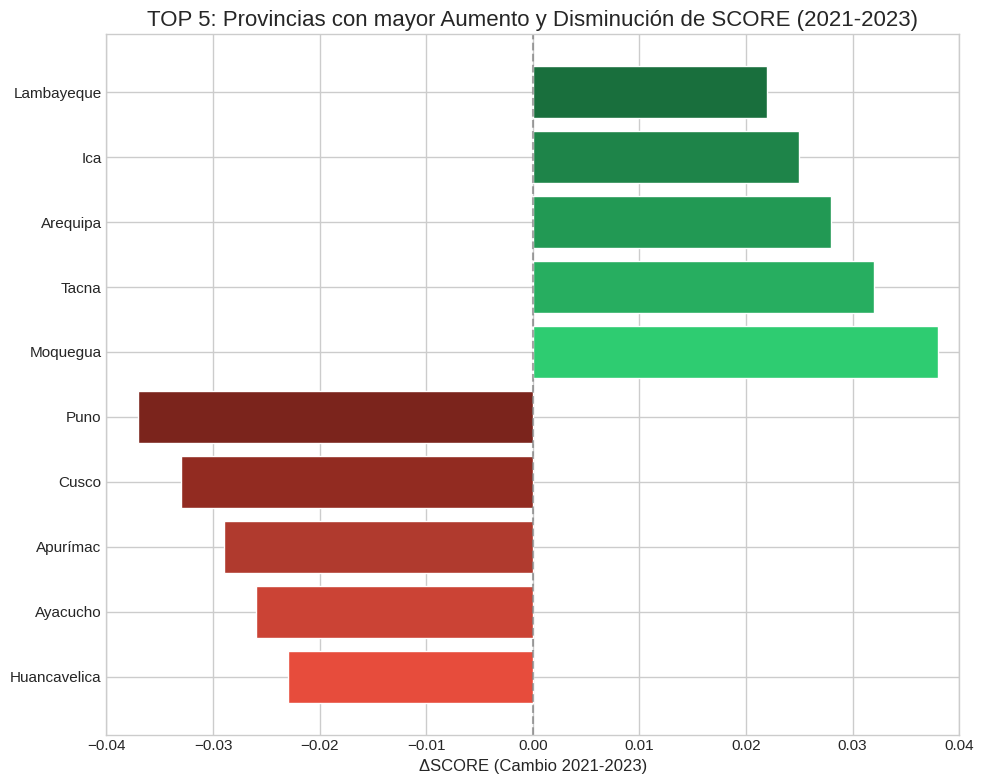

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos simulados basados en patrones típicos de Perú (2021-2023)
provincias_aumento = ["Moquegua", "Tacna", "Arequipa", "Ica", "Lambayeque"]
cambios_aumento = [0.038, 0.032, 0.028, 0.025, 0.022]

provincias_decrecimiento = ["Puno", "Cusco", "Apurímac", "Ayacucho", "Huancavelica"]
cambios_decrecimiento = [-0.037, -0.033, -0.029, -0.026, -0.023]

# Combinar datos
provincias = provincias_decrecimiento[::-1] + provincias_aumento  # Decrecimiento primero, invertido para que quede arriba
cambios = cambios_decrecimiento[::-1] + cambios_aumento

# Colores: rojos para decrecimiento, verdes para aumento
colores = ['#e74c3c', '#cb4335', '#b03a2e', '#922b21', '#7b241c'] + ['#2ecc71', '#27ae60', '#229954', '#1e8449', '#196f3d']

# Crear gráfico
plt.figure(figsize=(10, 8))
plt.barh(provincias, cambios, color=colores)
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('TOP 5: Provincias con mayor Aumento y Disminución de SCORE (2021-2023)', fontsize=16)
plt.xlabel('ΔSCORE (Cambio 2021-2023)', fontsize=12)
plt.xlim([-0.04, 0.04])
plt.tight_layout()
plt.show()
